# Домашнее задание "Проблема качества данных"
Преподаватель: Алексей Миронов, Наталья Баданина, Дарья Максимова

Необходимо запустить практическую часть занятия, и посмотреть самому то, о чём говорили на лекции. По образу практики, попробуйте создать искусственный датасет с лишними столбцами. Целевую метку, при правильной обработке данных, формируйте таким образом, чтобы без затруднений её смогла описать линейная модель. Ориентируйтесь на то, что было показано во время занятия, и каждый шаг описывайте в markdown. Здесь важно видеть ваш ход мысли. Не бойтесь ошибиться или написать не то. Данное задание не имеет какого-то “правильного” решения. Цель - достичь базового понимания проблемы. Чем больше вы фантазируете, тем лучше :) Тем не менее, старайтесь представить те ситуации, которые по-вашему мнению могли бы быть в реальных данных. Успеха!


In [287]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression

Создаем датасет с антропометрическими параметрами взрослого человека,

Целевой признак - рост

18 97


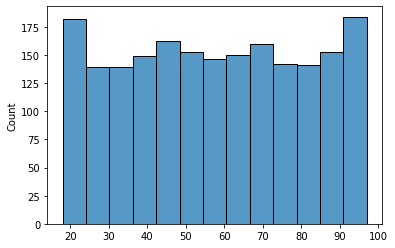

In [288]:
# Возраст не особо информативный признак
n_samples = 1000
age = np.random.choice(80, n_samples * 2) + 18
print(age.min(), age.max())
sns.histplot(age);

Вес должен коррелировать с возрастом и целевой переменной - ростом

Добавим шум +- 3

Двухмодальное распределение

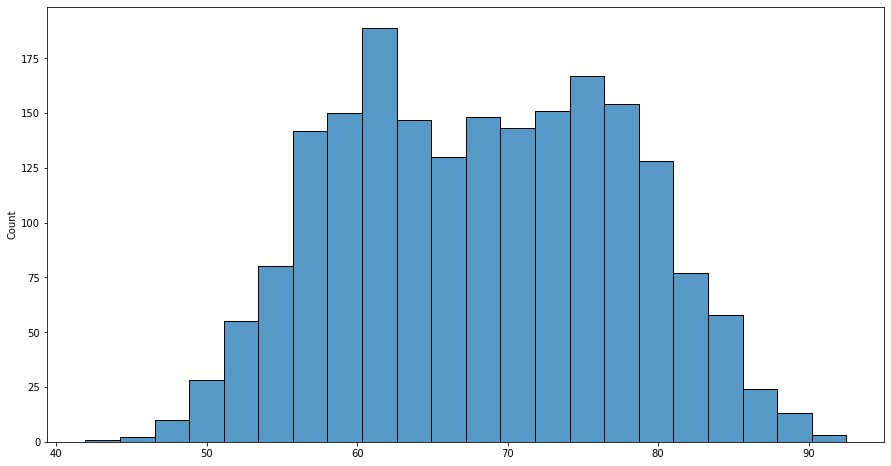

In [289]:
weight_man = np.random.choice(age, n_samples) * 0.1 + 70 + np.random.normal(0, 5, n_samples)
weight_woman = np.random.choice(age, n_samples) * 0.1 + 55 + np.random.normal(0, 5, n_samples)
weight = np.hstack((weight_man, weight_woman))
plt.figure(figsize=(15,8))
sns.histplot(weight);


Размер ноги (стопы) - должен быть сильным признаком

Также двухмодальное распределение

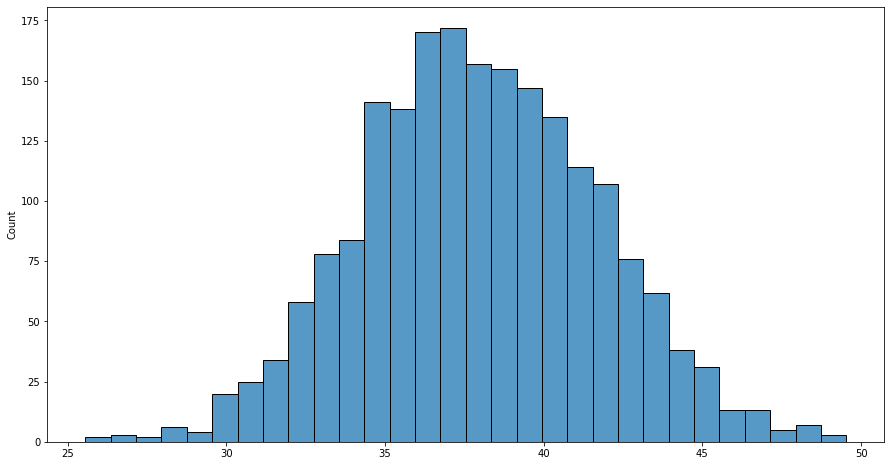

In [290]:
foot_size_m = np.random.normal(40, 3, n_samples) + np.random.normal(0, 1, n_samples)
foot_size_w = np.random.normal(36, 3, n_samples) + np.random.normal(0, 1, n_samples)

foot_size = np.hstack((foot_size_m, foot_size_w))

plt.figure(figsize=(15,8))
sns.histplot(foot_size);

В формировании целевого признака  не учитываем возраст,

Фактически зависимоть конечно же есть, но она яво не линейная

<AxesSubplot:ylabel='Count'>

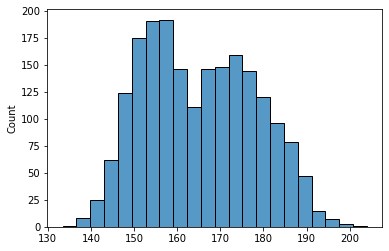

In [317]:

# height =  0.7 * weight + 4.1 * foot_size - 40
height =  0.025 * weight * foot_size + 100
# height[height < 140] = np.nan
# height[height > 220] = np.nan

sns.histplot(height)

In [318]:
data = pd.DataFrame({'age': age, 'weight': weight, 'foot_size': foot_size, 'height': height})
data.head(5)

,age,weight,foot_size,height
0,41,73.886709,39.424612,172.823870
1,51,73.999049,49.408890,191.405272
2,39,71.791161,39.875446,171.567613
3,97,87.540907,40.057447,187.666632
4,70,72.704153,42.826425,177.841474


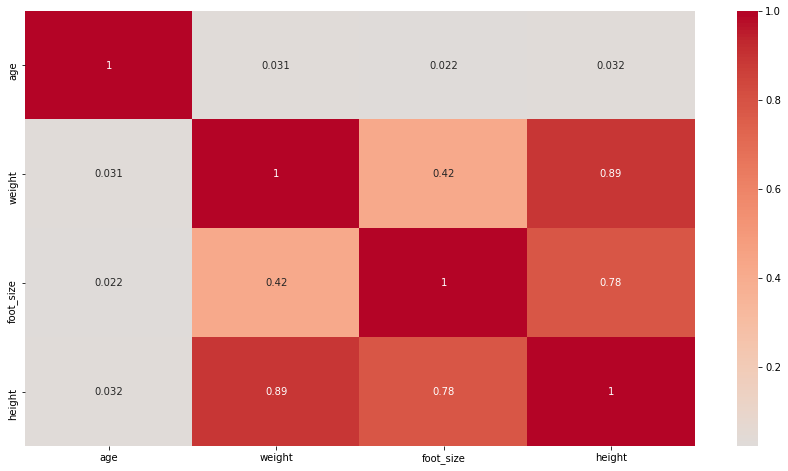

In [319]:
# Корреляция Пирсона
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot=True, center=0, cmap= 'coolwarm');

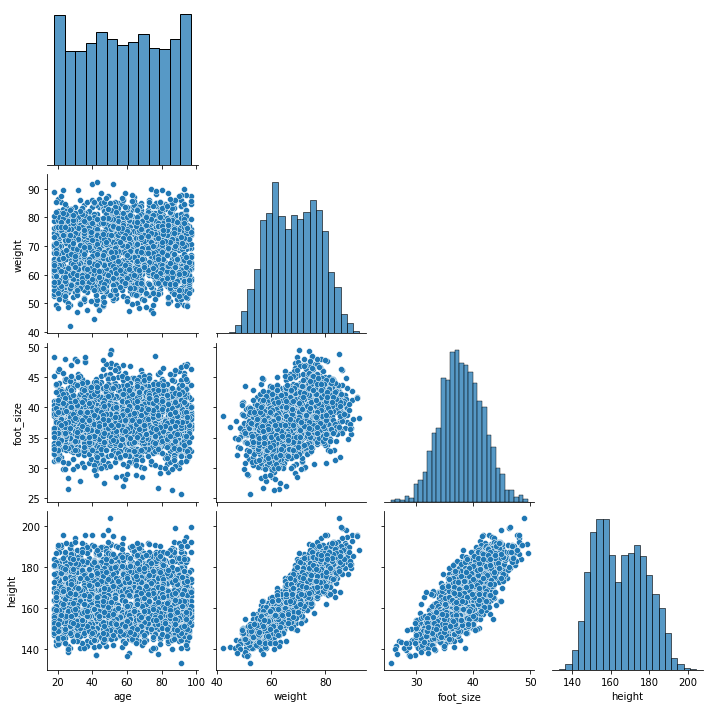

In [321]:
sns.pairplot(data, corner=True);

In [322]:
data.dropna(inplace=True)

X = data[['age', 'weight', 'foot_size']]
y = data['height']



reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['age', 'weight', 'foot_size']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [-4.65040315e-04  9.49214122e-01  1.70975754e+00]
Bias: 35.47562677598947
Error: 0.5652607089553168


In [323]:
X = data[['weight', 'foot_size']]
y = data['height']


reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['weight', 'foot_size']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [0.94918362 1.7097255 ]
Bias: 35.45210729337916
Error: 0.5655838923130894


Модель без лишней переменной не точнее ?
потому, что возраст зависит от веса

Добвим новый признак - пол

его можно сгенерировать исходя из размера стопы и веса:

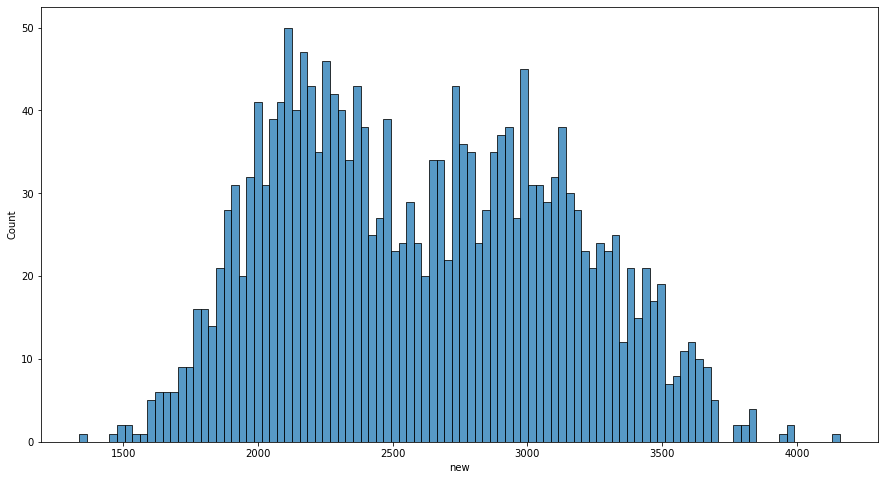

In [324]:
# промежуточный признак 
data['new'] = data['foot_size'] * data['weight']
plt.figure(figsize=(15,8))
sns.histplot(data['new'], bins=100);


/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


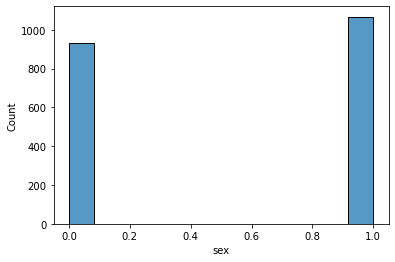

In [325]:
# Формируем новый признак
threshold = 2500

data['sex'] = 0
data.sex[data['new'] > threshold] = 1
sns.histplot(data['sex']);

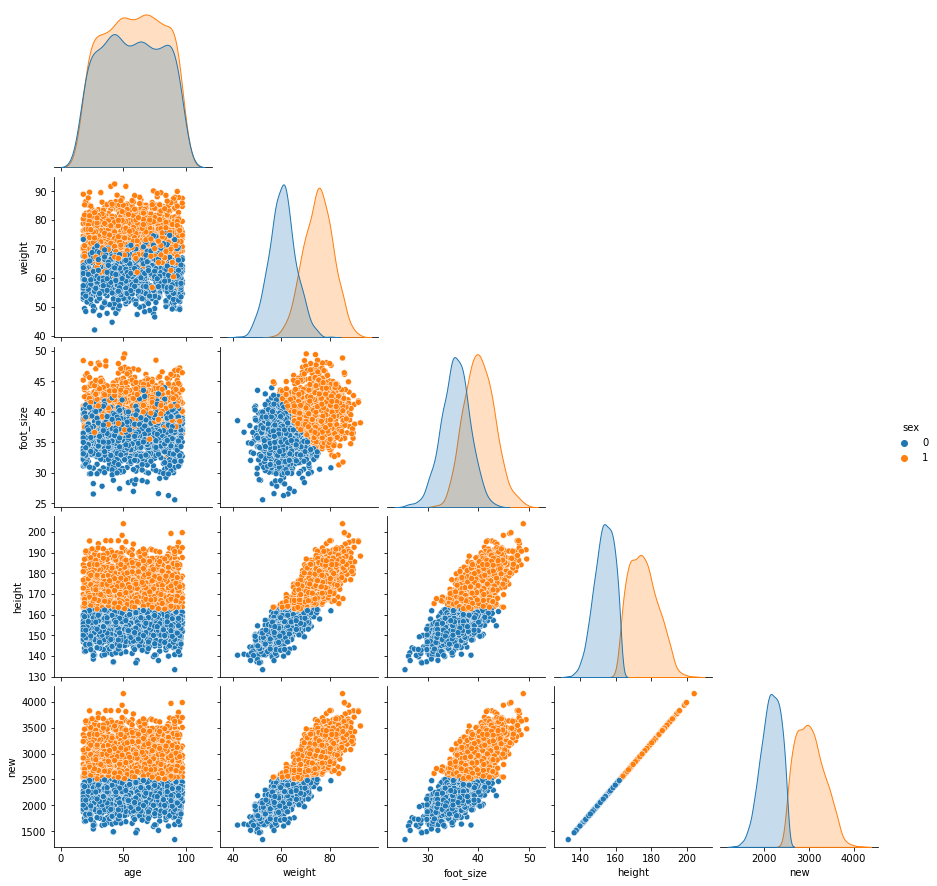

In [326]:
sns.pairplot(data, corner=True, hue='sex');

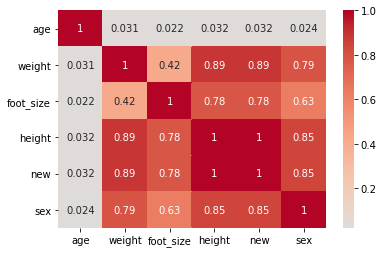

In [327]:
sns.heatmap(data.corr(), annot=True, center=0, cmap= 'coolwarm');

Крреляция нового признака и целевого - 0,97

In [331]:
X = data[['age', 'weight', 'foot_size', 'new', 'sex']]
y = data['height']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(X)
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [-6.98502676e-18  7.77156117e-16  1.47950228e-15  2.50000000e-02
  3.02441584e-16]
Bias: 99.99999999999986
Error: 1.533351223770296e-14


Мoдель с одним новым признаком

In [332]:
X = data[['new']]
y = data['height']
reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(data[['foot_size']])
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [0.025]
Bias: 99.99999999999997
Error: 64.21318570751406


Добавим полиноминальные признаки

In [336]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

poly = PolynomialFeatures(2)
X = poly.fit_transform(data[['age', 'weight', 'foot_size', 'new', 'sex']])

Здесь стандартизирую признаки, чтобы видеть их влияние
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = data['height']

reg = LinearRegression().fit(X, y)
print('Weights: {}'.format(reg.coef_))
print('Bias: {}'.format(reg.intercept_))

pred_values = reg.predict(X)
print('Error: {}'.format(mean_absolute_error(pred_values, y)))

Weights: [ 0.00000000e+00  7.36734858e-16 -4.24185354e-14 -8.18662694e-14
  1.25000000e-02  9.97635559e-15 -2.27030187e-18 -4.85290942e-18
 -1.58830873e-17  1.60424039e-19 -1.35335221e-16  3.09744295e-16
  1.25000000e-02 -1.83072629e-17 -7.76558939e-16  1.12459524e-15
 -2.83904391e-17 -2.13000643e-15  2.03287907e-19  4.89516842e-17
  9.97000392e-15]
Bias: 100.00000000000146
Error: 4.6767922867729793e-14
